In [4]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
import math
from tqdm import tqdm

### Read in data

In [38]:
somatic_mutation_file = 'Data/SOM/cohortMAF.2025-06-10.maf'
somatic_mutation_file = 'Data/TCGA/SOM/nulton_somatic_mutation_cohort.csv'
gtf_file = 'Data/TCGA/SOM/gencode.v48.annotation.gtf'

In [6]:
#somatic_mutation_download =pd.read_csv(somatic_mutation_file, sep='\t', comment = '#')
somatic_mutation_download = pd.read_csv(somatic_mutation_file)
somatic_mutation_download['Case ID'] = somatic_mutation_download['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('-').tolist()

In [7]:
somatic_mutation_download

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,COSMIC,hotspot,tumor_bam_uuid,normal_bam_uuid,RNA_Support,RNA_depth,RNA_ref_count,RNA_alt_count,callers,Case ID
0,ACTRT2,140625,BI,GRCh38,chr1,3022240,3022240,+,Missense_Mutation,SNP,...,COSM4659187,N,28534053-eaa4-4063-818e-b5a882910abe,35957e0a-8b49-4a6b-aac8-bf2066eb1228,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CN-4737
1,KIF1B,23095,BI,GRCh38,chr1,10334576,10334576,+,Missense_Mutation,SNP,...,NaN,N,28534053-eaa4-4063-818e-b5a882910abe,35957e0a-8b49-4a6b-aac8-bf2066eb1228,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CN-4737
2,COL8A2,1296,BI,GRCh38,chr1,36098111,36098111,+,Missense_Mutation,SNP,...,NaN,N,28534053-eaa4-4063-818e-b5a882910abe,35957e0a-8b49-4a6b-aac8-bf2066eb1228,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CN-4737
3,SZT2,23334,BI,GRCh38,chr1,43435262,43435262,+,Frame_Shift_Del,DEL,...,NaN,N,28534053-eaa4-4063-818e-b5a882910abe,35957e0a-8b49-4a6b-aac8-bf2066eb1228,Unknown,NaN,NaN,NaN,mutect2;varscan2,TCGA-CN-4737
4,ST3GAL3,6487,BI,GRCh38,chr1,43824852,43824852,+,Intron,SNP,...,NaN,N,28534053-eaa4-4063-818e-b5a882910abe,35957e0a-8b49-4a6b-aac8-bf2066eb1228,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CN-4737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86955,C19orf47,126526,BI,GRCh38,chr19,40322053,40322053,+,Missense_Mutation,SNP,...,NaN,N,45ec8d82-e4e6-4eb9-b3a0-6a16d929fcc9,3761a520-1166-4383-97af-2c3244c7f58f,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-MZ-A6I9
86956,ZNF155,7711,BI,GRCh38,chr19,43996817,43996825,+,In_Frame_Del,DEL,...,NaN,N,45ec8d82-e4e6-4eb9-b3a0-6a16d929fcc9,3761a520-1166-4383-97af-2c3244c7f58f,Unknown,NaN,NaN,NaN,mutect2;pindel;varscan2,TCGA-MZ-A6I9
86957,ZNF135,7694,BI,GRCh38,chr19,58068051,58068051,+,Nonsense_Mutation,SNP,...,NaN,N,45ec8d82-e4e6-4eb9-b3a0-6a16d929fcc9,3761a520-1166-4383-97af-2c3244c7f58f,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-MZ-A6I9
86958,FOXR2,139628,BI,GRCh38,chrX,55623864,55623864,+,Silent,SNP,...,NaN,N,45ec8d82-e4e6-4eb9-b3a0-6a16d929fcc9,3761a520-1166-4383-97af-2c3244c7f58f,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-MZ-A6I9


In [8]:
somatic_mutation_download[somatic_mutation_download['Hugo_Symbol'] == 'TP53']

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,Variant_Type,...,COSMIC,hotspot,tumor_bam_uuid,normal_bam_uuid,RNA_Support,RNA_depth,RNA_ref_count,RNA_alt_count,callers,Case ID
40,TP53,7157,BI,GRCh38,chr17,7675109,7675109,+,Missense_Mutation,SNP,...,COSM1649383;COSM44801;COSM5029896;COSM562629;C...,Y,28534053-eaa4-4063-818e-b5a882910abe,35957e0a-8b49-4a6b-aac8-bf2066eb1228,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CN-4737
125,TP53,7157,BI,GRCh38,chr17,7673806,7673806,+,Missense_Mutation,SNP,...,COSM10891;COSM1645249;COSM3388172;COSM99950,Y,5dd9980b-242e-4a0e-92fc-9a7dba3d4c8b,16cb5074-10ff-461f-ba07-14beffe3a62a,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-T2-A6WZ
126,TP53,7157,BI,GRCh38,chr17,7674858,7674858,+,Splice_Site,SNP,...,COSM118939;COSM118940;COSM118941;COSM13586;COS...,Y,5dd9980b-242e-4a0e-92fc-9a7dba3d4c8b,16cb5074-10ff-461f-ba07-14beffe3a62a,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-T2-A6WZ
488,TP53,7157,BI,GRCh38,chr17,7674238,7674238,+,Missense_Mutation,SNP,...,COSM10646;COSM251396;COSM251397;COSM251398;COS...,Y,b8d37cb3-44f9-4b74-9005-a6acb648ee9b,1b0c2702-5291-477c-88fd-9b19e7da466d,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-BA-6870
654,TP53,7157,BI,GRCh38,chr17,7673826,7673826,+,Missense_Mutation,SNP,...,COSM3970345;COSM3970346;COSM437485;COSM44092,Y,9787e022-8ff3-45f8-aabd-4900d263b6d7,21d34dcc-56bd-4430-a71e-bdec521a0878,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CN-6024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85627,TP53,7157,BI,GRCh38,chr17,7673806,7673806,+,Missense_Mutation,SNP,...,COSM10891;COSM1645249;COSM3388172;COSM99950,Y,67450695-0a16-4700-8cdc-ddfaed6d50d2,83c6b3e5-3ae1-45bb-aa7d-d0251a60c2ea,Unknown,NaN,NaN,NaN,muse;mutect2,TCGA-BA-A6DA
85906,TP53,7157,BI,GRCh38,chr17,7674256,7674256,+,Missense_Mutation,SNP,...,COSM10731;COSM116672;COSM116673;COSM116674;COS...,Y,d54dee42-ea0a-4aad-be06-ee678cb1cf15,56213de1-a4dc-4b8f-b781-8b6dd349a895,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-BA-5555
86037,TP53,7157,BI,GRCh38,chr17,7675206,7675206,+,Nonsense_Mutation,SNP,...,COSM11166;COSM126985;COSM126986;COSM126987;COS...,Y,9b2f30e0-9044-4cb8-8248-72c830b652ab,8eb01bce-46ef-4580-a62f-fa20be8776d7,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-CN-6997
86381,TP53,7157,BI,GRCh38,chr17,7675143,7675143,+,Missense_Mutation,SNP,...,COSM10670;COSM131480;COSM131481;COSM131482;COS...,Y,584921c2-d00a-4035-b594-b869adaa5186,00b9ef18-488f-4eed-b397-4eca980194b5,Unknown,NaN,NaN,NaN,muse;mutect2;varscan2,TCGA-DQ-5629


In [9]:
len(set(somatic_mutation_download['Case ID']))

499

In [10]:
len(set(somatic_mutation_download['Hugo_Symbol']))

16477

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'TTN'),
  Text(1, 0, 'TP53'),
  Text(2, 0, 'MUC16'),
  Text(3, 0, 'CSMD3'),
  Text(4, 0, 'FAT1'),
  Text(5, 0, 'SYNE1'),
  Text(6, 0, 'LRP1B'),
  Text(7, 0, 'CDKN2A'),
  Text(8, 0, 'DNAH5'),
  Text(9, 0, 'NOTCH1'),
  Text(10, 0, 'PCLO'),
  Text(11, 0, 'USH2A'),
  Text(12, 0, 'RYR2'),
  Text(13, 0, 'PIK3CA'),
  Text(14, 0, 'AHNAK'),
  Text(15, 0, 'KMT2D'),
  Text(16, 0, 'DST'),
  Text(17, 0, 'PLEC'),
  Text(18, 0, 'FLG'),
  Text(19, 0, 'NSD1')])

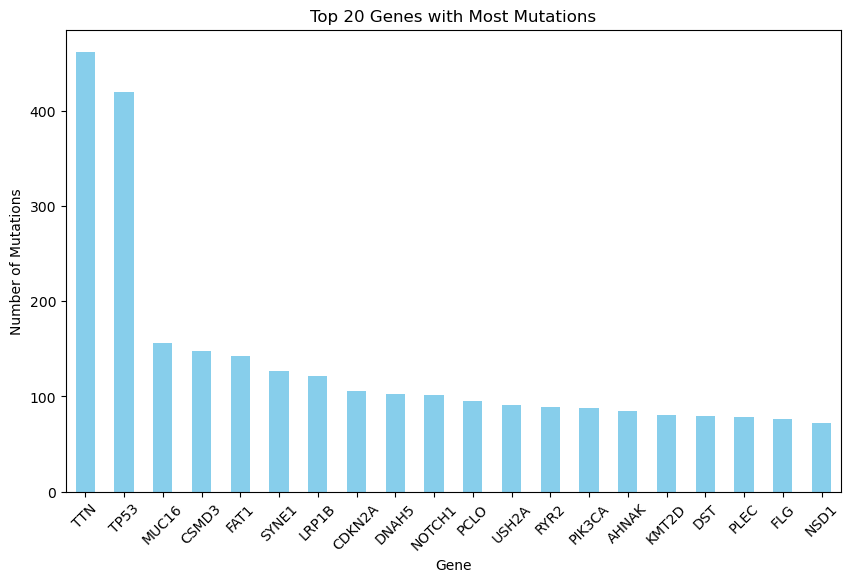

In [11]:
### calculate the number of mutations per gene, plot the top 20 genes with the most mutations
top_genes = somatic_mutation_download['Hugo_Symbol'].value_counts().head(20)
plt.figure(figsize=(10, 6))
top_genes.plot(kind='bar', color='skyblue')
plt.title('Top 20 Genes with Most Mutations')
plt.xlabel('Gene')
plt.ylabel('Number of Mutations')
plt.xticks(rotation=45)

Text(0, 0.5, 'Frequency')

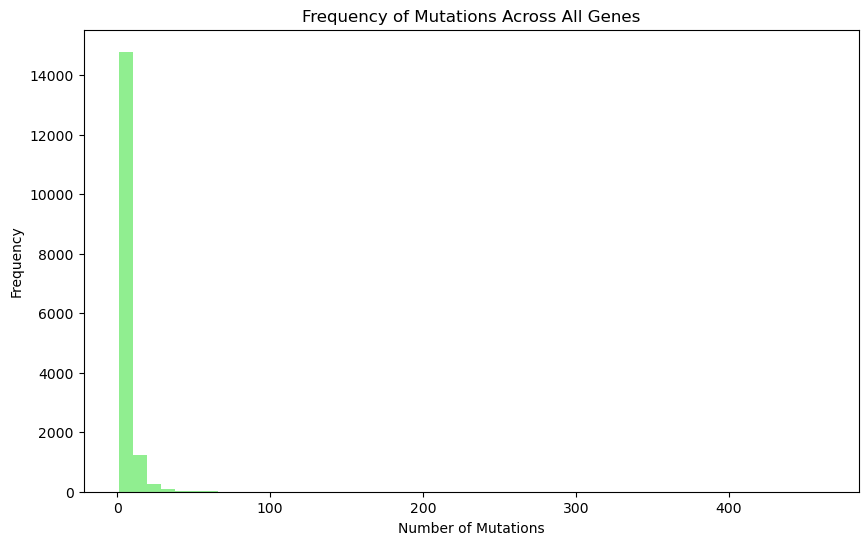

In [12]:
### plot the frequency of mutations across all genes
plt.figure(figsize=(10, 6))
somatic_mutation_download['Hugo_Symbol'].value_counts().plot(kind='hist', bins=50, color='lightgreen')
plt.title('Frequency of Mutations Across All Genes')
plt.xlabel('Number of Mutations')
plt.ylabel('Frequency')


In [13]:
print(len(set(somatic_mutation_download['tumor_bam_uuid'])))
print(len(set(somatic_mutation_download['normal_bam_uuid'])))

501
499


In [14]:
print(len(set(somatic_mutation_download['tumor_bam_uuid'])))
print(len(set(somatic_mutation_download['normal_bam_uuid'])))

501
499


### HPV

In [15]:
hpv_positive_patients = pd.read_csv('Results/HPV results/HPV positive patients.csv')
hpv_negative_patients = pd.read_csv('Results/HPV results/HPV negative patients.csv')

In [16]:
HPV_positive_df = pd.read_csv('Results/HPV results/HPV positive patients.csv')
HPV_positive_cases = [x for x in HPV_positive_df['TCGA CASE ID']]
HPV_positive_cases = list(set(HPV_positive_cases))
HPV_negative_df = pd.read_csv('Results/HPV results/HPV negative patients.csv')
HPV_negative_cases = [x for x in HPV_negative_df['TCGA CASE ID']]
HPV_negative_cases = list(set(HPV_negative_cases))

In [17]:
### overlap of hpv postive cases and somatic mutation cases
overlap_cases = set(HPV_positive_cases).intersection(set(somatic_mutation_download['Case ID']))
print("number of overlapping cases between HPV positive cases and somatic mutation cases: ", len(overlap_cases))

### overlap of hpv negative cases and somatic mutation cases
overlap_negative_cases = set(HPV_negative_cases).intersection(set(somatic_mutation_download['Case ID']))
print("number of overlapping cases between HPV negative cases and somatic mutation cases: ", len(overlap_negative_cases))

### those that are not hpv postive case ids in somatic mutation cases
non_hpv_positive_cases = list(set(somatic_mutation_download['Case ID']) - set(HPV_positive_cases))
print("number of non HPV positive cases in somatic mutation cases: ", len(non_hpv_positive_cases))

number of overlapping cases between HPV positive cases and somatic mutation cases:  66
number of overlapping cases between HPV negative cases and somatic mutation cases:  433
number of non HPV positive cases in somatic mutation cases:  433


In [18]:
hpv_positive_patients

,Unnamed: 0,TCGA CASE ID
0,0,TCGA-HD-A634
1,1,TCGA-P3-A5QE
2,2,TCGA-BA-A4IH
3,3,TCGA-BB-7866
4,4,TCGA-DQ-7596
...,...,...
67,67,TCGA-CV-6939
68,68,TCGA-DQ-7591
69,69,TCGA-IQ-A61I
70,70,TCGA-HD-8314


In [23]:
def num_overlap(list1,list2):
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)

    # Find the intersection of the two sets
    overlap = set1.intersection(set2)

    # Get the number of overlapping values
    num_overlap = len(overlap)
    return num_overlap

In [24]:
num_overlap(hpv_positive_patients['TCGA CASE ID'], somatic_mutation_download['Case ID'])

66

## Mutation count

In [25]:
# Step 1: Parse GTF to extract gene metadata and CDS lengths
def parse_gtf(gtf_file):
    """
    Parse a GENECODE GTF file unzipped and extract gene-related metadata from CDS entries.
    Output a table with gene_id, gene_name, transcript_id, gene_type, tag, and total CDS length.
    """
    gene_cds_lengths = {}

    # Open and read the GTF file
    with open(gtf_file, 'r') as f:
        for line in tqdm(f, desc='Parsing GTF file'):
            ## Skip comment lines
            if line.startswith('#'):
                continue
            ## Split the line into fields
            ## GTF format: seqname, source, feature, start, end, score, strand, frame, attribute
            ## We are interested in the 'CDS' feature
            fields = line.strip().split('\t')
            ## Check if the feature is 'CDS'
            if fields[2] == 'CDS':
                ### extract gene_id and gene_name from attributes
                # Extract attributes and parse gene_id and gene_name
                # The attributes are in the 9th field, which is a semicolon-separated list
                # of key-value pairs.
                # Example: gene_id "ENSG00000123456"; gene_name "GeneName"; ...
                attributes = fields[8].split('; ')
                attr_dict = {
                    attr.split(' ')[0]: attr.split(' ')[1].strip('"')
                    for attr in attributes if ' ' in attr
                }
                # Extract relevant attributes
                # gene_id, gene_name, transcript_id, gene_type, tag, and calculate CDS length
                ## Extract attributes and parse gene_id and gene_name
                ## The attributes are in the 9th field, which is a semicolon-separated list
                ## of key-value pairs.
                ## Example: gene_id "ENSG00000123456"; gene_name "GeneName"; ...
                gene_id = attr_dict.get('gene_id')
                gene_name = attr_dict.get('gene_name')
                transcript_id = attr_dict.get('transcript_id')
                gene_type = attr_dict.get('gene_type')
                tag = attr_dict.get('tag')
                ### Calculate CDS length
                cds_length = int(fields[4]) - int(fields[3]) + 1

                ### if the values are missing for gene_id, gene_name, transcript_id, gene_type, tag
                if not gene_id or not gene_name or not transcript_id or not gene_type or not tag:
                    continue

                # Initialize the gene_id in the dictionary if not already present
                if gene_id not in gene_cds_lengths:
                    gene_cds_lengths[gene_id] = {
                        'gene_name': gene_name,
                        'transcript_id': transcript_id,
                        'gene_type': gene_type,
                        'tag': tag,
                        'cds_length': 0
                    }
                # Add the CDS length to the gene_id entry
                gene_cds_lengths[gene_id]['cds_length'] += cds_length
    
    # Convert to DataFrame
    gene_cds_df = pd.DataFrame.from_dict(gene_cds_lengths, orient='index').reset_index()
    gene_cds_df.columns = ['gene_id', 'gene_name', 'transcript_id', 'gene_type', 'tag', 'cds_length']
    return gene_cds_df  

In [46]:
somatic_mutation_file

'Data/TCGA/SOM/nulton_somatic_mutation_cohort.csv'

In [57]:
# Step 2: Analyze somatic mutations using gene metadata
def somatic_mutation_gene_count(somatic_mutation_file, cases, gene_lengths_df):
    """
    Count and normalize somatic mutations per gene, calculate cohort frequency, and perform significance testing.
    """
    #somatic_mutation = pd.read_csv(somatic_mutation_file, sep='\t', comment='#')
    somatic_mutation = pd.read_csv(somatic_mutation_file)
    somatic_mutation['Case ID'] = somatic_mutation['Tumor_Sample_Barcode'].str.split('-').str[0:3].str.join('-').tolist()
    # Ensure 'Case ID' is in the DataFrame
    #print(somatic_mutation['Case ID'])
    somatic_mutation = somatic_mutation[somatic_mutation['Case ID'].isin(cases)]
    case_column = 'Case ID'

    # Filter for non-synonymous mutations
    non_synonymous_types = ['Frame_Shift_Del', 'Frame_Shift_Ins',
                             'In_Frame_Del', 'In_Frame_Ins',
                            'Missense_Mutation', 'Nonsense_Mutation', 
                            'Nonstop_Mutation', 'Splice_Site', 'Translation_Start_Site']
    
    # Filter the DataFrame for non-synonymous mutations
    somatic_mutation = somatic_mutation[
        somatic_mutation['Variant_Classification'].isin(non_synonymous_types)
    ]

    # Load gene lengths from the provided DataFrame
    # Convert gene lengths DataFrame to a dictionary for quick access
    gene_lengths = gene_lengths_df.set_index('gene_name')['cds_length'].to_dict()

    # Count mutations per gene
    mutation_dict = {}
    for mut in tqdm(somatic_mutation['Hugo_Symbol'], desc='Counting mutations'):
        mutation_dict[mut] = mutation_dict.get(mut, 0) + 1
    # Create a DataFrame from the mutation dictionary
    mutation_gene_df = pd.DataFrame(list(mutation_dict.items()), columns=['Gene', 'Count'])

    ### calculate mutation frequency by case id
    cohort_frequency = somatic_mutation.groupby('Hugo_Symbol')[case_column].nunique().reset_index()
    cohort_frequency.columns = ['Gene', 'Cohort_Frequency']
    # Merge mutation counts with cohort frequency
    ### now both mutation count in general and frequency by case id are available
    mutation_gene_df = mutation_gene_df.merge(cohort_frequency, on='Gene')

    # Normalize mutation counts by gene length
    # Ensure gene lengths are available for normalization
    if not gene_lengths:
        raise ValueError("Gene lengths data is empty or not provided.")
    # Normalize mutation counts by gene length
    # This assumes gene_lengths is a dictionary with gene names as keys and lengths as values
    mutation_gene_df['Normalized_Count'] = mutation_gene_df.apply(
        lambda row: row['Count'] / gene_lengths.get(row['Gene'], 1), axis=1
    )

    ### calculate a normalized mutation frequency by case id
    mutation_gene_df['Normalized_Cohort_Frequency'] = mutation_gene_df.apply(
        lambda row: row['Cohort_Frequency'] / gene_lengths.get(row['Gene'], 1), axis=1
    )

    ### Perform binomial test for significance
    # Calculate total mutations in the dataset
    total_mutations = somatic_mutation.shape[0]
    #somatic_mutation = pd.read_csv(somatic_mutation_file, sep='\t', comment='#')
    somatic_mutation = pd.read_csv(somatic_mutation_file)
    non_syn_syn_mutations = somatic_mutation.shape[0]
    binom_p_vals = [binomtest(x, non_syn_syn_mutations, 1/len(gene_lengths)).pvalue for x in mutation_gene_df['Count']]
    mutation_gene_df['P_Value'] = binom_p_vals
    print(binom_p_vals)
    ### Adjust p-values for multiple testing using Benjamini-Hochberg method
    mutation_gene_df['Adjusted_P_Value'] = multipletests(mutation_gene_df['P_Value'], method='fdr_bh')[1]
    ### column for significance
    mutation_gene_df['Significant'] = mutation_gene_df['Adjusted_P_Value'] < 0.05
    
    ### Calculate an empirical p-value based on a null distribution of mutation counts
    all_mutation_values = mutation_gene_df['Count'].values
    all_mutation_values = np.random.permutation(all_mutation_values)  # Shuffle mutation counts
    empirical_p_values = []
    num_simulations = 10000  # Number of simulations for empirical p-value calculation
    gene_names = mutation_gene_df['Gene'].tolist()
    gene_lengths_array = np.array([gene_lengths.get(gene, 1) for gene in gene_names])  # Get gene lengths for normalization
    gene_probs = gene_lengths_array / gene_lengths_array.sum()  # Calculate probabilities based on gene lengths
    # Generate a null distribution of mutation counts based on gene probabilities
    # This uses a multinomial distribution where the total number of mutations is the sum of all mutation counts
    # and the probabilities are based on gene lengths
    np.random.seed(42)  # For reproducibility
    num_simulations = 10000  # Number of simulations for empirical p-value calculation
    # Generate a null distribution of mutation counts based on gene probabilities
    ### a multinomial distribution is used because it allows for the simulation of counts across multiple categories (genes) based on specified probabilities
    ### the inputs for the multinomial distribution are the total number of mutations and the probabilities for each gene, 
    ### this allows for the generation of a distribution of mutation counts that reflects the expected distribution of mutations across genes based on their lengths
    ### total_mutations = somatic_mutation.shape[0] # total number of mutations in the dataset
    ### gene_probs = gene_lengths_array / gene_lengths_array.sum()  # Calculate probabilities based on gene lengths
    ### num_simulations = 10000  # Number of simulations for empirical p-value calculation
    ### null distribution will now be a 2D array where each row represents a simulated count of mutations across genes 
    ### and each column represents a gene
    ### to call the counts for a specific gene, you can index into the array using the gene's index
    ### i.e. null_distribution[:, gene_index] will give you the simulated counts for the gene at gene_index
    null_distribution = np.random.multinomial(total_mutations, gene_probs, size=num_simulations) 
    
    empirical_p_values = []
    for gene in gene_names:
        observed_count = mutation_dict.get(gene, 0)
        # Calculate the empirical p-value for each gene
        # The empirical p-value is the proportion of simulated counts that are greater than or equal to the observed count
        if gene in gene_lengths:
            gene_index = gene_names.index(gene)
            simulated_counts = null_distribution[:, gene_index]
            empirical_p_value = np.mean(simulated_counts >= observed_count)
        else:
            empirical_p_value = 1.0  # If the gene is not in the gene lengths, set empirical p-value to 1.
        empirical_p_values.append(empirical_p_value)

    # Add empirical p-values to the DataFrame
    mutation_gene_df['Empirical_P_Value'] = empirical_p_values
    ### multiple testing correction for empirical p-values
    mutation_gene_df['Adjusted_Empirical_P_Value'] = multipletests(mutation_gene_df['Empirical_P_Value'], method='fdr_bh')[1]

    mutation_gene_df = mutation_gene_df.sort_values(by=['Adjusted_Empirical_P_Value', 'Count'], ascending=[True, False])


    return mutation_gene_df

# Step 3: Run the full pipeline
def run_mutation_analysis_pipeline(mutation_file, gene_length_file, case_list):
    gene_lengths_df = parse_gtf(gene_length_file)
    results = somatic_mutation_gene_count(mutation_file, case_list, gene_lengths_df)
    return results

# Step 4: Visualize results
def visualize_results(results):
    top_genes_raw = results.nlargest(20, 'Count')
    plt.figure(figsize=(10, 6))
    plt.barh(top_genes_raw['Gene'], top_genes_raw['Count'], color='skyblue')
    plt.xlabel('Raw Mutation Count')
    plt.ylabel('Gene')
    plt.title('Top 20 Genes by Raw Mutation Count')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('top_genes_raw.png')
    plt.show()

    top_genes_normalized = results.nlargest(20, 'Normalized_Count')
    plt.figure(figsize=(10, 6))
    plt.barh(top_genes_normalized['Gene'], top_genes_normalized['Normalized_Count'], color='salmon')
    plt.xlabel('Normalized Mutation Count')
    plt.ylabel('Gene')
    plt.title('Top 20 Genes by Normalized Mutation Count')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('top_genes_normalized.png')
    plt.show()


In [48]:
test_list = [x[0:12] for x in list(set(somatic_mutation_download['Tumor_Sample_Barcode']))]
print(num_overlap(test_list,  list(set(HPV_positive_df['TCGA CASE ID'])) ))
print(num_overlap(test_list,  list(set(HPV_negative_df['TCGA CASE ID'])) ))

66
433


In [29]:
HPV_positive_idx= []
HPV_negative_idx = []
for i,val in tqdm(enumerate(list(somatic_mutation_download['Tumor_Sample_Barcode']))):
    test_val = val[0:12]
    if test_val in HPV_positive_cases:
        HPV_positive_idx.append(i)
    elif test_val in HPV_negative_cases:
        HPV_negative_idx.append(i)

86960it [00:00, 442312.01it/s]


In [30]:
print(len(HPV_positive_idx))
print(len(HPV_negative_idx))
print(len(HPV_positive_idx)+ len(HPV_negative_idx))

8372
78588
86960


In [31]:
# somatic_mutation_file = 'Data/SOM/cohortMAF.2025-06-10.maf'
# gtf_file = 'Data/SOM/gencode.v48.annotation.gtf'

### HPV+

In [58]:
hpv_positive_cases = list(hpv_positive_patients['TCGA CASE ID'])
print(len(set(hpv_positive_cases)))

72


In [59]:
somatic_mutation_download['Case ID']

0        TCGA-CN-4737
1        TCGA-CN-4737
2        TCGA-CN-4737
3        TCGA-CN-4737
4        TCGA-CN-4737
             ...     
86955    TCGA-MZ-A6I9
86956    TCGA-MZ-A6I9
86957    TCGA-MZ-A6I9
86958    TCGA-MZ-A6I9
86959    TCGA-MZ-A6I9
Name: Case ID, Length: 86960, dtype: object

In [60]:
hpv_positive_case_somatic = somatic_mutation_download[somatic_mutation_download['Case ID'].isin(hpv_positive_cases)]

In [61]:
len(set(hpv_positive_case_somatic['Case ID']))

66

In [62]:
hpv_pos_results = run_mutation_analysis_pipeline(somatic_mutation_file, gtf_file, hpv_positive_cases)

Parsing GTF file: 4107087it [00:07, 549946.31it/s]
Counting mutations: 100%|██████████| 6077/6077 [00:00<00:00, 5247845.46it/s]


[0.4586220575033093, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.8060446223441999, 0.1422684783101249, 0.4586220575033093, 9.921993025914447e-19, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.8060446223441999, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.4586220575033093, 0.1422684783101249, 0.1422684783101249, 0.4586220575033093, 1.0, 0.1422684783101249, 0.4586220575033093, 0.4586220575033093, 0.1422684783101249, 0.4586220575033093, 0.4586220575033093, 0.1422684783101249, 0.4586220575033093, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 2.4838626711559975e-06, 1.0, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.1422684783101249, 0.4586220575033093, 0.1422684783101249, 0.4586220575033093, 0.4586220575033093, 0.1422684783101249, 0.8060446223441999, 0.1422684783101249, 1.0, 0.142268478310124

In [63]:
hpv_pos_results.sort_values(by='Adjusted_Empirical_P_Value', ascending=True).head(20)

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
78,PIK3CA,18,17,0.002182,0.002061,5.769295e-07,0.001285,True,0.0000,0.000000
918,ZNF750,11,8,0.003502,0.002547,4.403595e-03,0.184970,False,0.0000,0.000000
1292,ATAD5,8,3,0.001446,0.000542,8.146748e-02,0.184970,False,0.0000,0.000000
355,FAM135B,6,5,0.001229,0.001024,3.295339e-01,0.425955,False,0.0000,0.000000
2215,DEFB114,2,2,0.009662,0.009662,4.586221e-01,0.488225,False,0.0002,0.074217
1889,GNA15,3,3,0.002674,0.002674,8.060446e-01,0.817426,False,0.0002,0.074217
3436,SOCS6,4,1,0.001027,0.000257,1.000000e+00,1.000000,False,0.0002,0.074217
408,ZNF99,4,3,0.001543,0.001157,1.000000e+00,1.000000,False,0.0001,0.074217
846,LRRIQ1,6,3,0.000899,0.000449,3.295339e-01,0.425955,False,0.0002,0.074217
690,CCDC191,6,6,0.001148,0.001148,3.295339e-01,0.425955,False,0.0001,0.074217


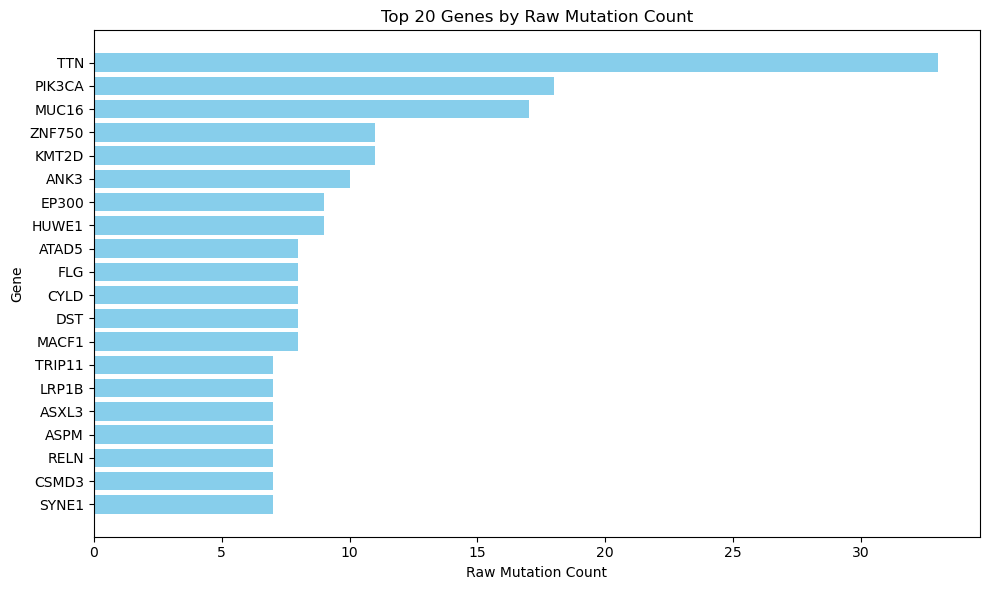

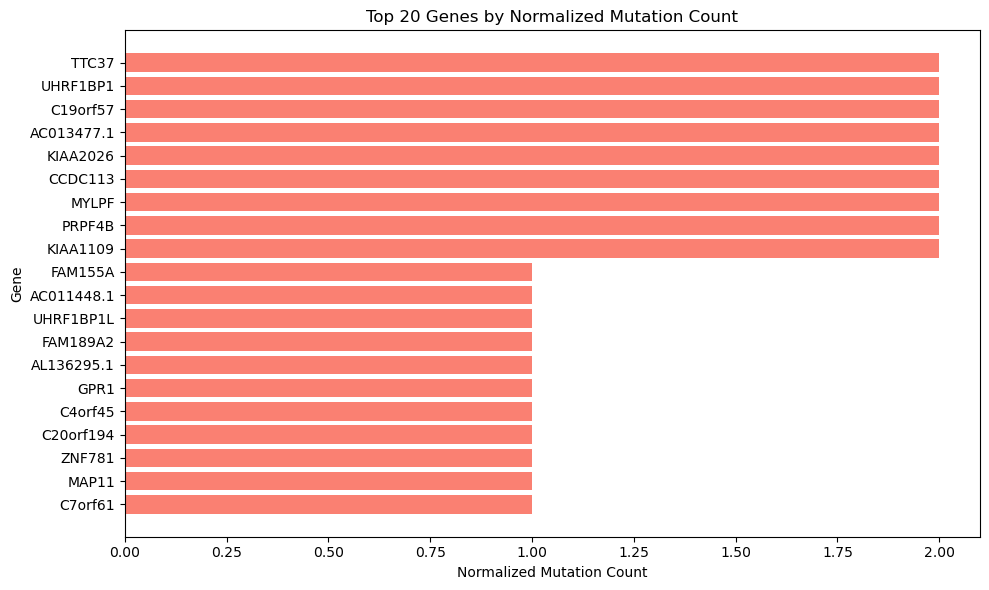

In [64]:
visualize_results(hpv_pos_results)

In [65]:
hpv_pos_results[hpv_pos_results['Adjusted_Empirical_P_Value']<.05]

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
78,PIK3CA,18,17,0.002182,0.002061,5.769295e-07,0.001285,True,0.0,0.0
918,ZNF750,11,8,0.003502,0.002547,4.403595e-03,0.184970,False,0.0,0.0
1292,ATAD5,8,3,0.001446,0.000542,8.146748e-02,0.184970,False,0.0,0.0
355,FAM135B,6,5,0.001229,0.001024,3.295339e-01,0.425955,False,0.0,0.0


In [66]:
hpv_pos_results[hpv_pos_results['Adjusted_P_Value']<.05]

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
78,PIK3CA,18,17,0.002182,0.002061,5.769295e-07,1.284534e-03,True,0.0000,0.000000
37,MUC16,17,9,0.000097,0.000051,2.483863e-06,3.686880e-03,True,0.8432,0.996461
11,TTN,33,25,0.000027,0.000020,9.921993e-19,4.418263e-15,True,1.0000,1.000000


In [67]:
hpv_pos_results.to_csv('Results/SOM results/HPV positive genes.csv', index=False)

In [68]:
top_hpv_results = hpv_pos_results[hpv_pos_results['Adjusted_Empirical_P_Value']<.05][hpv_pos_results['Adjusted_P_Value']<.05]

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_60433/1829293761.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_hpv_results = hpv_pos_results[hpv_pos_results['Adjusted_Empirical_P_Value']<.05][hpv_pos_results['Adjusted_P_Value']<.05]


In [69]:
top_hpv_results

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
78,PIK3CA,18,17,0.002182,0.002061,5.769295e-07,0.001285,True,0.0,0.0


In [70]:
top_hpv_results.to_csv('Results/SOM results/HPV positive top genes.csv', index=False)

### HPV- 

In [71]:
hpv_negative_cases = somatic_mutation_download[~somatic_mutation_download['Case ID'].isin(hpv_positive_cases)]['Case ID']
print(len(set(hpv_negative_cases)))

433


In [72]:
hpv_neg_results = run_mutation_analysis_pipeline(somatic_mutation_file, gtf_file, hpv_negative_cases)

Parsing GTF file: 4107087it [00:07, 556602.73it/s]
Counting mutations: 100%|██████████| 57516/57516 [00:00<00:00, 4907532.78it/s]


[1.0, 0.3295338790218679, 1.0, 0.004403594814545786, 0.4586220575033093, 1.0, 0.8060446223441999, 0.4586220575033093, 0.1422684783101249, 0.0, 0.21297182494522007, 2.4838626711559975e-06, 0.6233330670210367, 1.2337321274378386e-19, 0.3295338790218679, 5.270484219696039e-95, 0.6233330670210367, 0.01192016926952921, 0.8060446223441999, 0.3295338790218679, 0.21297182494522007, 2.4838626711559975e-06, 0.0015023250044041067, 0.8060446223441999, 1.0, 1.0, 0.0, 0.8060446223441999, 0.6233330670210367, 0.6233330670210367, 3.8896122676060874e-05, 0.00047581610617498395, 1.0, 0.6233330670210367, 0.6233330670210367, 0.4586220575033093, 1.0, 0.081467484574598, 0.3295338790218679, 1.969974009331864e-32, 1.0, 0.3295338790218679, 0.4586220575033093, 1.0, 5.3309985101360084e-09, 0.8060446223441999, 8.926893955701974e-13, 0.21297182494522007, 0.1422684783101249, 0.6233330670210367, 0.4586220575033093, 0.3295338790218679, 1.0, 0.6233330670210367, 0.21297182494522007, 0.1422684783101249, 0.458622057503309

In [73]:
hpv_neg_results

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
26,TP53,405,345,0.014275,0.012160,0.000000e+00,0.000000e+00,True,0.0000,0.0
221,FAT1,133,104,0.007515,0.005876,3.013304e-145,1.466776e-141,True,0.0000,0.0
1196,CSMD3,113,82,0.002712,0.001968,5.720354e-116,2.088358e-112,True,0.0000,0.0
1201,CDKN2A,105,101,0.027668,0.026614,1.131084e-104,3.303443e-101,True,0.0000,0.0
15,SYNE1,98,75,0.000854,0.000654,5.270484e-95,1.099498e-91,True,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...
14597,SP8,1,1,0.000334,0.000334,1.422685e-01,3.739285e-01,False,0.7795,1.0
14598,RIC8A,1,1,0.000128,0.000128,1.422685e-01,3.739285e-01,False,0.9814,1.0
14599,IFTAP,1,1,0.000104,0.000104,1.422685e-01,3.739285e-01,False,0.9923,1.0
14600,AMHR2,1,1,0.000196,0.000196,1.422685e-01,3.739285e-01,False,0.9234,1.0


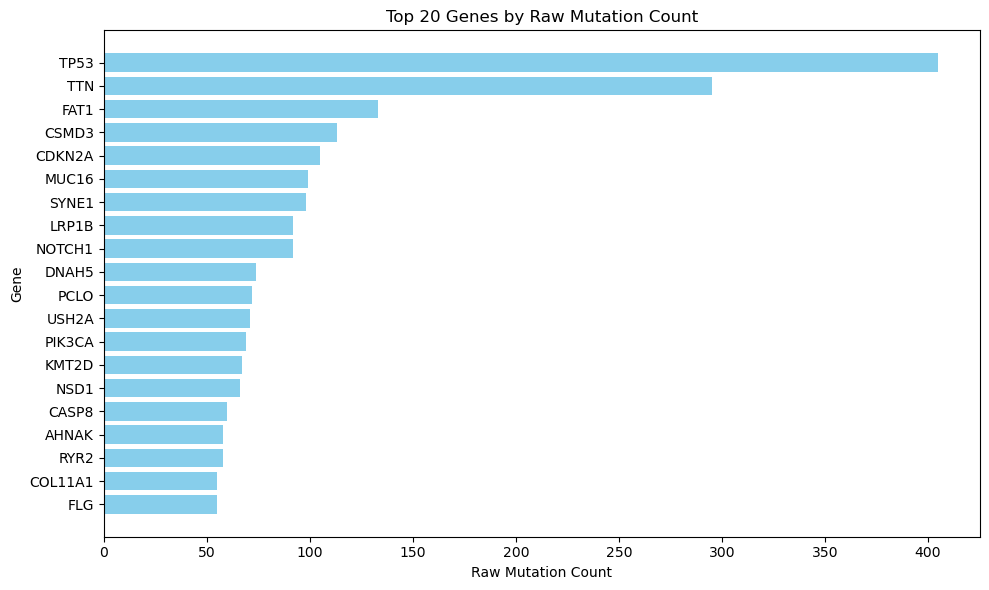

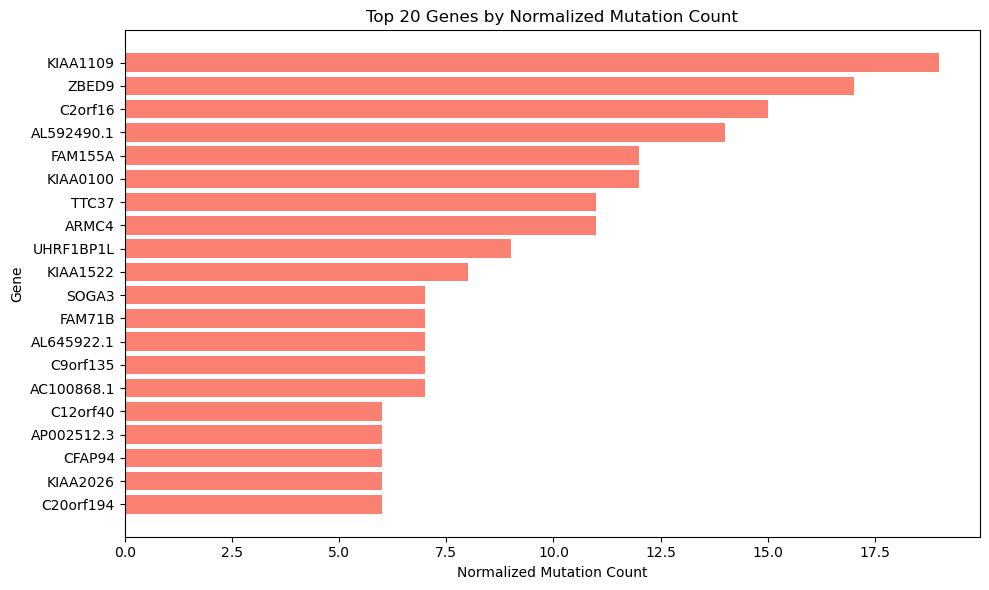

In [74]:
visualize_results(hpv_neg_results)

In [75]:
print(len(set(hpv_neg_results['Gene'])))

14603


In [76]:
hpv_neg_results[hpv_neg_results['Adjusted_P_Value']<.05]

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
26,TP53,405,345,0.014275,0.012160,0.000000e+00,0.000000e+00,True,0.0000,0.0
221,FAT1,133,104,0.007515,0.005876,3.013304e-145,1.466776e-141,True,0.0000,0.0
1196,CSMD3,113,82,0.002712,0.001968,5.720354e-116,2.088358e-112,True,0.0000,0.0
1201,CDKN2A,105,101,0.027668,0.026614,1.131084e-104,3.303443e-101,True,0.0000,0.0
15,SYNE1,98,75,0.000854,0.000654,5.270484e-95,1.099498e-91,True,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...
5044,FAM155A,12,12,12.000000,12.000000,1.502325e-03,3.406592e-02,True,1.0000,1.0
5306,DYNC2H1,12,12,0.000329,0.000329,1.502325e-03,3.406592e-02,True,0.9578,1.0
5345,ZFHX3,12,12,0.000392,0.000392,1.502325e-03,3.406592e-02,True,0.8422,1.0
5653,MAST4,12,9,0.000304,0.000228,1.502325e-03,3.406592e-02,True,0.9804,1.0


In [77]:
hpv_neg_results[hpv_neg_results['Adjusted_Empirical_P_Value']<.05]

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
26,TP53,405,345,0.014275,0.012160,0.000000e+00,0.000000e+00,True,0.0000,0.000000
221,FAT1,133,104,0.007515,0.005876,3.013304e-145,1.466776e-141,True,0.0000,0.000000
1196,CSMD3,113,82,0.002712,0.001968,5.720354e-116,2.088358e-112,True,0.0000,0.000000
1201,CDKN2A,105,101,0.027668,0.026614,1.131084e-104,3.303443e-101,True,0.0000,0.000000
15,SYNE1,98,75,0.000854,0.000654,5.270484e-95,1.099498e-91,True,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...
8659,PRSS1,5,5,0.002381,0.002381,6.233331e-01,8.377078e-01,False,0.0044,0.049464
1360,IGSF5,4,4,0.003276,0.003276,1.000000e+00,1.000000e+00,False,0.0044,0.049464
2260,BSPRY,4,4,0.003317,0.003317,1.000000e+00,1.000000e+00,False,0.0044,0.049464
2451,RTP2,3,3,0.004444,0.004444,8.060446e-01,9.009315e-01,False,0.0044,0.049464


In [78]:
hpv_neg_results.to_csv('Results/SOM results/HPV negative genes.csv', index=False)

In [79]:
top_hpv_neg_results = hpv_neg_results[hpv_neg_results['Adjusted_Empirical_P_Value']<.05][hpv_neg_results['Adjusted_P_Value']<.05]

/var/folders/5p/swntgnbj3fbfxkx02kt3fq980000gn/T/ipykernel_60433/2030490385.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_hpv_neg_results = hpv_neg_results[hpv_neg_results['Adjusted_Empirical_P_Value']<.05][hpv_neg_results['Adjusted_P_Value']<.05]


In [80]:
len(top_hpv_neg_results)

351

In [81]:
top_hpv_neg_results.sort_values(by='Adjusted_Empirical_P_Value', ascending=True).tail(20)

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value
1990,MAP1A,19,19,0.001084,0.001084,1.271612e-07,8.327064e-06,True,0.0019,0.025906
2720,ANKHD1-EIF4EBP3,13,12,0.001332,0.001230,4.758161e-04,1.284352e-02,True,0.0020,0.026918
1485,DZIP3,13,12,0.001326,0.001224,4.758161e-04,1.284352e-02,True,0.0020,0.026918
4092,CD163L1,13,13,0.001300,0.001300,4.758161e-04,1.284352e-02,True,0.0022,0.029153
769,PTPRM,18,17,0.001097,0.001036,5.769295e-07,3.290977e-05,True,0.0023,0.030123
884,CACNA2D1,16,15,0.001168,0.001095,1.011964e-05,4.346387e-04,True,0.0023,0.030123
2256,VIRMA,14,12,0.001215,0.001042,1.405650e-04,4.501471e-03,True,0.0025,0.032222
167,KMT2D,67,59,0.000742,0.000653,4.870595e-55,5.080378e-52,True,0.0026,0.033189
2155,SH3BP4,13,10,0.001314,0.001011,4.758161e-04,1.284352e-02,True,0.0026,0.033189
2344,SELP,15,13,0.001178,0.001021,3.889612e-05,1.456410e-03,True,0.0027,0.034019


In [82]:
top_hpv_neg_results['RANKING'] = top_hpv_neg_results['Adjusted_Empirical_P_Value'].rank()

In [83]:
top_hpv_neg_results[top_hpv_neg_results['Gene']=='SELP']

,Gene,Count,Cohort_Frequency,Normalized_Count,Normalized_Cohort_Frequency,P_Value,Adjusted_P_Value,Significant,Empirical_P_Value,Adjusted_Empirical_P_Value,RANKING
2344,SELP,15,13,0.001178,0.001021,0.000039,0.001456,True,0.0027,0.034019,341.5


In [84]:
top_hpv_neg_results.to_csv('Results/SOM results/HPV negative top genes.csv', index=False)